In [1]:
import pandas as pd
from collections import Counter
import pprint
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt

Load pre-trained embedding. See readme for training your own.

In [3]:
%load_ext autoreload
%autoreload 2
from code.feiii_transformers import _EmbeddingHolder
embedding = _EmbeddingHolder()
embedding.load('embedding')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [5]:
%load_ext autoreload
%autoreload 2

from code.feiii_experiment import evaluate, kfold
from code.feiii_data import DataHolder
from code.feiii_pipeline import FeiiiPipeline


def pp(obj):
    return pprint.pformat(obj).replace('\n','<br />')

data = DataHolder(eval_docs=2)
print('done')

out = '<table><tr><th></th><th>TRAINING</th><th>TESTING SET</th></tr>'
out+= '<tr><td>#ROWS</td><td>'+str(len(data.train_full))+'</td><td>'+str(len(data.test))+'</td></tr>'
out+= '<tr><td>ROLES</td><td>'+pp(dict(Counter(data.train_full['grp'])))+'</td><td>'+pp(dict(Counter(data.test['grp'])))+'</td></tr>'
out+= '<tr><td>DOCUMENTS</td><td>'+pp(dict(Counter(data.train_full['SOURCE'])))+'</td><td>'+pp(dict(Counter(data.test['SOURCE'])))+'</td></tr>'
out+= '<tr><td>COMPANIES</td><td>'+pp(dict(Counter(data.train_full['FILER_NAME'])))+'</td><td>'+pp(dict(Counter(data.test['FILER_NAME'])))+'</td></tr>'
out+= '<tr><td>Expert ratings</td><td>'
for c in data.train_full.filter(regex=("RATING")):
    out+= str(c)+' '+str(Counter(data.train_full[c]))+'<br/>'
out+= '</td><td>none</td></tr>'
out+= '</table>'

HTML(out)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
reading file STATE-STREET_2016.csv with 23 entries.
reading file STATE-STREET_2014.csv with 26 entries.
reading file PNC_2016.csv with 33 entries.
reading file PNC_2014.csv with 38 entries.
reading file JPM_2016.csv with 52 entries.
reading file COMERICA_2016.csv with 11 entries.
reading file FIFTH-THIRD_2014.csv with 36 entries.
reading file CITIGROUP_2014.csv with 52 entries.
reading file AMERICAN-EXPRESS_2015.csv with 11 entries.
reading file BANK-OF-AMERICA_2015.csv with 74 entries.
reading file ALLY_2016.csv with 44 entries.
reading file CITIGROUP_2016.csv with 50 entries.
reading file ALLY_2014.csv with 40 entries.
reading file SUNTRUST_2013.csv with 35 entries.
reading file DISCOVER_2014.csv with 41 entries.
reading file MORGAN-STANLEY_2015.csv with 128 entries.
reading file SUNTRUST_2016.csv with 27 entries.
reading file BBT_2014.csv with 14 entries.
reading file GENERAL-ELECTRIC_2013.csv wi

,TRAINING,TESTING SET
#ROWS,975,900
ROLES,"{'affiliate': 186, 'agent': 61, 'counterpart': 64, 'guarantor': 34, 'insurer': 19, 'issuer': 129, 'seller': 20, 'servicer': 21, 'trustee': 420, 'underwriter': 21}","{'affiliate': 129, 'agent': 40, 'counterpart': 108, 'guarantor': 28, 'insurer': 47, 'issuer': 98, 'seller': 49, 'servicer': 57, 'trustee': 304, 'underwriter': 40}"
DOCUMENTS,"{'1393612-2013-FY': 41, '19617-2015-FY': 52, '28412-2015-FY': 11, '35527-2013-FY': 36, '35527-2014-FY': 46, '36270-m&t-2012': 21, '36270-m&t-2014': 21, '40545-2012-FY': 21, '40729-2013-FY': 40, '40729-2015-FY': 44, '4962-2014-FY': 11, '70858-2012-FY': 88, '70858-2014-FY': 74, '713676-2013-FY': 38, '713676-2015-FY': 33, '73124-2012-FY': 18, '750556-2012-FY': 35, '750556-2015-FY': 27, '831001-2013-FY': 52, '831001-2015-FY': 50, '895421-2014-FY': 128, '92230-2013-FY': 14, '927628-2012-FY': 25, '93751-2013-FY': 26, '93751-2015-FY': 23}","{'1026214-2011-Q2': 64, '1026214-2013-FY': 99, '109380-2014-FY': 13, '1390777-2015-Q1': 26, '1393612-2010-FY': 11, '19617-2011-FY': 67, '28412-2012-FY': 11, '310522-2012-FY': 59, '310522-2013-Q2': 21, '316709-2015-FY': 14, '36104-_2015-FY': 8, '36270-m&t-2010': 18, '40545-2015-FY': 27, '40729-2012-Q3': 23, '4962-2015-FY': 19, '70858-2013-FY': 81, '713676-2014-FY': 33, '73124-2015-FY': 28, '831001-2011-FY': 37, '886982-2013-FY': 36, '895421-2015-FY': 134, '91576-2012-FY': 10, '92230-2010-FY': 21, '927628-2010-FY': 20, '93751-2010-FY': 20}"
COMPANIES,"{'AMERICAN EXPRESS CO': 11, 'Ally Financial Inc': 84, 'BANK OF AMERICA CORP': 162, 'BB&T CORP': 14, 'CAPITAL ONE FINANCIAL CORP': 25, 'CITIGROUP INC': 102, 'COMERICA INC': 11, 'Discover Financial Services': 41, 'FIFTH THIRD BANCORP': 82, 'GENERAL ELECTRIC CO': 21, 'JPMORGAN CHASE & CO': 52, 'M&T BANK CORP': 42, 'MORGAN STANLEY': 128, 'NORTHERN TRUST CORP': 18, 'PNC FINANCIAL SERVICES GROUP INC': 71, 'STATE STREET CORP': 49, 'SUNTRUST BANKS INC': 62}","{'AMERICAN EXPRESS CO': 19, 'Ally Financial Inc': 23, 'BANK OF AMERICA CORP': 81, 'BB&T CORP': 21, 'Bank of New York Mellon Corp': 26, 'CAPITAL ONE FINANCIAL CORP': 20, 'CITIGROUP INC': 37, 'COMERICA INC': 11, 'Discover Financial Services': 11, 'FEDERAL_HOME_LOAN_MORTGAGE_CORP': 163, 'FEDERAL_NATIONAL_MORTGAGE_ASSOCIATION_FANNIE_MAE': 80, 'GENERAL ELECTRIC CO': 27, 'GOLDMAN SACHS GROUP INC': 36, 'JPMORGAN CHASE & CO': 67, 'KEYCORP': 10, 'M&T BANK CORP': 18, 'MORGAN STANLEY': 134, 'NORTHERN TRUST CORP': 28, 'PNC FINANCIAL SERVICES GROUP INC': 33, 'SCHWAB_CHARLES_CORP ': 14, 'STATE STREET CORP': 20, 'US_BANCORP': 8, 'ZIONS BANCORPORATION': 13}"
Expert ratings,"RATING_EXPERT_1 Counter({nan: 566, 'Highly relevant': 149, 'Neutral': 139, 'Relevant': 93, 'Irrelevant': 28})RATING_EXPERT_1.1 Counter({nan: 749, 'Highly relevant': 101, 'Neutral': 83, 'Relevant': 35, 'Irrelevant': 7})RATING_EXPERT_10 Counter({nan: 955, 'Relevant': 20})RATING_EXPERT_2 Counter({nan: 609, 'Relevant': 163, 'Neutral': 131, 'Highly relevant': 58, 'Irrelevant': 14})RATING_EXPERT_3 Counter({nan: 915, 'Irrelevant': 29, 'Neutral': 15, 'Highly relevant': 8, 'Relevant': 8})RATING_EXPERT_4 Counter({nan: 940, 'Relevant': 23, 'Neutral': 5, 'Highly relevant': 5, 'Irrelevant': 2})RATING_EXPERT_5 Counter({nan: 895, 'Neutral': 41, 'Relevant': 29, 'Highly relevant': 7, 'Irrelevant': 3})RATING_EXPERT_6 Counter({nan: 915, 'Relevant': 34, 'Highly relevant': 10, 'Irrelevant': 10, 'Neutral': 6})RATING_EXPERT_7 Counter({nan: 900, 'Neutral': 36, 'Relevant': 27, 'Highly relevant': 10, 'Irrelevant': 2})RATING_EXPERT_9 Counter({nan: 901, 'Highly relevant': 62, 'Irrelevant': 10, 'Neutral': 1, 'Relevant': 1})",none


In [216]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
import code.feiii_transformers as ft

params_ = {
    'cv': {
        'ngram_range': (1, 3),
        'min_df': 0.4,
        'max_df': 0.6,
        'stop_words': 'english'
    },
    'tt': {
        'use_idf': True,
        'sublinear_tf': True,
    },
    'emb': {
        'num_files': 30,
        'num_epoch': 20
    },
    'logit': {
        'loss': 'log',  # ['hinge', 'log', 'perceptron','huber'] # for pred_proba: log or modified_huber
        'penalty': 'l2',
        'shuffle': True,
        'alpha': 1e-4,
        'n_iter': 15,
        'random_state': 42,
        'class_weight': 'balanced'
    },
    'rf': {
        'n_estimators': 20,
        'criterion': 'gini',  # gini or entropy
        'max_features': 'auto',  # int, float, auto, sqrt, log2, None
        'random_state': 42,
        'class_weight': 'balanced'
    },
    'svm': {
        'C': 1.0,
        'kernel': 'sigmoid',  # linear’, ‘poly’, ‘rbf’, ‘sigmoid’
        'probability': True,
        'class_weight': 'balanced',
        'decision_function_shape': 'ovr',  # ovo, ovr
        'random_state': 42
    }
}

def pipeline():
    pipln = 'bow'
    if pipln == 'all_union':
        line = [
            ('union', FeatureUnion(
                transformer_list=[
                    ('emb', Pipeline([
                        ('emb', ft.Embedder(embedding))
                    ])),
                    ('syntax', Pipeline([
                        ('feats', ft.SyntaxFeatures()),
                    ])),
                    ('bow', Pipeline([
                        ('lem', ft.Lemmatiser()),
                        ('vect', CountVectorizer(**params_['cv'])),
                        ('tfidf', TfidfTransformer(**params_['tt']))
                    ]))
                ],
                transformer_weights={
                    'syntax': 1,
                    'bow': 1
                },
            )),
            # ('clf', SGDClassifier(**params_['svm']))
            ('clf', SGDClassifier(**params_['logit']))
            # ('clf', RandomForestClassifier(**params_['rf']))
        ]
    elif pipln == 'all_vote':
        line = [
            ('clf', VotingClassifier(
                voting='soft',  # hard, soft
                # weights=[2,1,2],
                estimators=[
                    ('syn', Pipeline([
                        ('feats', ft.SyntaxFeatures()),
                        ('rf', RandomForestClassifier(**params_['rf'])),
                        # ('svc', SVC(**params_['svm']))
                    ])),
                    ('emb', Pipeline([
                        ('emb', ft.Embedder(embedding)),
                        ('svc', SVC(**params_['svm']))
                    ])),
                    ('bow', Pipeline([
                        ('lem', ft.Lemmatiser()),
                        ('vect', CountVectorizer(**params_['cv'])),
                        ('tfidf', TfidfTransformer(**params_['tt'])),
                        ('svc', SVC(**params_['svm']))
                        # ('bclf', SGDClassifier(**params_['logit']))
                    ]))
                ]))]
    elif pipln == 'syn':
        line = [
            ('feats', ft.SyntaxFeatures()),
            ('clf', RandomForestClassifier(**params_['rf']))
        ]
    elif pipln == 'emb':
        line = [
            ('emb', ft.Embedder(embedding)),
            ('clf', SVC(**params_['svm']))
           # ('bclf', SGDClassifier(**params_['logit']))
        ]
    else:  # pipln == 'bow'
        line = [
            ('lem', ft.Lemmatiser()),
            ('vect', CountVectorizer(**params_['cv'])),
            ('tfidf', TfidfTransformer(**params_['tt'])),
            ('clf', SGDClassifier(**params_['logit']))
        ]
    return FeiiiPipeline(line=line, embedding=embedding)

def score_func(x):
    kind = 'mulmax'
    if kind=='last':
        xx = x[-1]
    elif kind=='mulmax':
        xx = x.argmax(axis=1)*x.max(axis=1)
    elif kind=='maxadjust':
        xx = np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,x.argmax(axis=1))])
    elif kind == '1234':
        xx = np.sum(x * np.array([1, 2, 3, 4]), axis=1)
    elif kind == '1246':
        xx = np.sum(x * np.array([1, 2, 4, 6]), axis=1)
    elif kind=='1245':
        xx = np.sum(x * np.array([1, 2, 4, 5]), axis=1)
    else:
        raise AttributeError('meh.')
        
    return (xx-xx.min())/(xx-xx.min()).max()

Execute the following line in case of errors during training.

In [15]:
data.shuffle_train_eval(n_docs_eval=3, max_tries=5)

# Train

In [217]:
fm, m, res, macro_res, conf_matrix_role, conf_matrix_full = evaluate(data, pipeline, score_func=score_func)

Items in training set: 923 (94.67%)
Items in eval set: 52
Items in test set: 900
 = 1875
Number of source documents: 50 total, 23 train, 2 eval 25 test
Absolute (training): IR 89.00, N 286.00, R 260.00, HR 288.00
Relative (training): IR 0.10, N 0.31, R 0.28, HR 0.31
Absolute (eval): IR 1.00, N 21.00, R 23.00, HR 7.00
Relative (eval): IR 0.02, N 0.40, R 0.44, HR 0.13
Role samples for AFFILIATE in train: 176, eval: 10, test: 129
Role samples for TRUSTEE in train: 414, eval: 6, test: 304
Role samples for UNDERWRITER in train: 19, eval: 2, test: 40
Role samples for COUNTERPART in train: 52, eval: 12, test: 108
Role samples for GUARANTOR in train: 33, eval: 1, test: 28
Role samples for SELLER in train: 14, eval: 6, test: 49
Role samples for AGENT in train: 56, eval: 5, test: 40
Role samples for ISSUER in train: 124, eval: 5, test: 98
Role samples for SERVICER in train: 18, eval: 3, test: 57
Role samples for INSURER in train: 17, eval: 2, test: 47
=== AFFILIATE ======
Items in training set: 

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:138: RuntimeWarning: invalid value encountered in true_divide



NDCG after 100x random order:
 > mean ndcg = 0.891778455129 | std = 0.0527277757265
NDCG for worst case (inverted best) order:
 > ndcg = 0.807731187357
Accuracy | role : 0.2
Accuracy | full : 0.4
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         3
   relevant       1.00      1.00      1.00         2
     highly       0.00      0.00      0.00         0

avg / total       0.40      0.40      0.40         5

[[0 0 0 0]
 [3 0 0 0]
 [0 0 2 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 0.89763
> NDCG Score | role | proba* | 0.89763
> NDCG Score | full | categ  | 1.00000
> NDCG Score | full | proba* | 1.00000
=== ISSUER ======
Items in training set: 124 (96.12%)
Items in eval set: 5
Items in test set: 98
 = 227
Number of source documents: 46 total, 23 train, 1 eval 22 test
Absolute (training): IR 32.00, N 42.00, R 28.00, HR 22.00
Relative (training): IR 0.26, N 0.34, R 0.23, HR 0.18
Ab

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:138: RuntimeWarning: invalid value encountered in true_divide


 1 eval 7 test
Absolute (training): IR 1.00, N 1.00, R 6.00, HR 9.00
Relative (training): IR 0.06, N 0.06, R 0.35, HR 0.53
Absolute (eval): IR 0.00, N 0.00, R 2.00, HR 0.00
Relative (eval): IR 0.00, N 0.00, R 1.00, HR 0.00
Role samples for INSURER in train: 17, eval: 2, test: 47
NDCG after 100x random order:
 > mean ndcg = 1.0 | std = 0.0
NDCG for worst case (inverted best) order:
 > ndcg = 1.0
Accuracy | role : 1.0
Accuracy | full : 0.5
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         0
   relevant       1.00      0.50      0.67         2
     highly       0.00      0.00      0.00         0

avg / total       1.00      0.50      0.67         2

[[0 0 0 0]
 [0 0 0 0]
 [1 0 1 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | full | categ  | 1.00000
> NDCG Score | full | proba* | 1.00000
=== TRUSTEE ======
Items in training

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:138: RuntimeWarning: invalid value encountered in true_divide
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:138: RuntimeWarning: invalid value encountered in true_divide


NDCG after 100x random order:
 > mean ndcg = 0.94580618128 | std = 0.037176652936
NDCG for worst case (inverted best) order:
 > ndcg = 0.920303207764
Accuracy | role : 0.333333333333
Accuracy | full : 0.666666666667
             precision    recall  f1-score   support

 irrelevant       0.00      0.00      0.00         0
    neutral       0.00      0.00      0.00         1
   relevant       0.67      1.00      0.80         2
     highly       0.00      0.00      0.00         0

avg / total       0.44      0.67      0.53         3

[[0 0 0 0]
 [0 0 1 0]
 [0 0 2 0]
 [0 0 0 0]]
> NDCG Score | role | categ  | 1.00000
> NDCG Score | role | proba* | 1.00000
> NDCG Score | full | categ  | 0.92030
> NDCG Score | full | proba* | 0.92030
=== SELLER ======
Items in training set: 14 (70.00%)
Items in eval set: 6
Items in test set: 49
 = 69
Number of source documents: 19 total, 8 train, 2 eval 9 test
Absolute (training): IR 0.00, N 1.00, R 12.00, HR 1.00
Relative (training): IR 0.00, N 0.07, R 0.86

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:138: RuntimeWarning: invalid value encountered in true_divide


# Evaluate trained classifier

In [218]:
pd.DataFrame(res).describe()

,acc_full,acc_role,baseline_rand,baseline_worst,f1_full,f1_role,ndcg_full,ndcg_full_proba,ndcg_role,ndcg_role_proba
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.413333,0.236667,0.936585,0.879891,0.375281,0.201429,0.959221,0.973540,0.937727,0.938482
std,0.351434,0.305687,0.060044,0.102573,0.355039,0.309894,0.066809,0.039162,0.081046,0.071892
min,0.000000,0.000000,0.821976,0.698437,0.000000,0.000000,0.801214,0.899479,0.801214,0.807731
25%,0.083333,0.000000,0.894575,0.807731,0.041667,0.000000,0.933031,0.947882,0.898095,0.898095
50%,0.400000,0.183333,0.952338,0.881749,0.314286,0.090476,1.000000,1.000000,0.985608,0.963038
75%,0.625000,0.333333,0.990425,0.980076,0.633333,0.291667,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


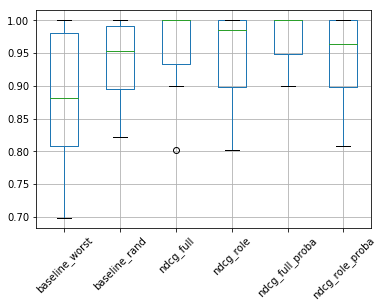

In [219]:
%matplotlib inline
pd.DataFrame(res)[['baseline_worst','baseline_rand','ndcg_full','ndcg_role','ndcg_full_proba','ndcg_role_proba']]\
    .boxplot(figsize=(5,8), rot=45)

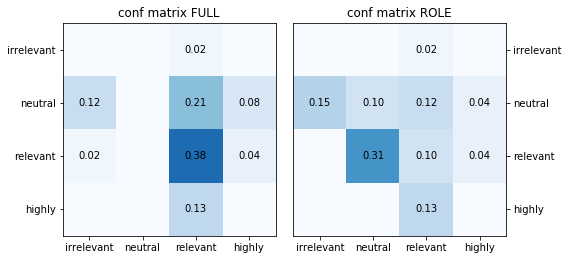

In [220]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm as colm
plt.figure(figsize=(8,5))
sub = plt.subplot(121)
normed = conf_matrix_full/conf_matrix_full.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
plt.title('conf matrix FULL')
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed.T[i][j]
        c='%.2f'%v if v>0.005 else ''
        sub.text(i, j, c, va='center', ha='center')



sub = plt.subplot(122)
normed = conf_matrix_role/conf_matrix_role.sum()
plt.imshow(normed, cmap=colm.Blues, vmax=0.5)
sub.yaxis.tick_right()
sub.set_yticks([0,1,2,3])
sub.set_yticklabels(['irrelevant', 'neutral','relevant', 'highly'])
sub.set_xticks([0,1,2,3])
sub.set_xticklabels(['irrelevant', 'neutral','relevant', 'highly'])

for i in range(normed.shape[0]):
    for j in range(normed.shape[1]):
        v = normed.T[i][j]
        c='%.2f'%v if v>0.01 else ''
        sub.text(i, j, c, va='center', ha='center')
        
plt.title('conf matrix ROLE')

plt.tight_layout()
plt.show()

# Save

affiliate 129
agent 40
counterpart 108
guarantor 28
insurer 47
issuer 98
seller 49
servicer 57
trustee 304
underwriter 40


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fde73627f98>], dtype=object)

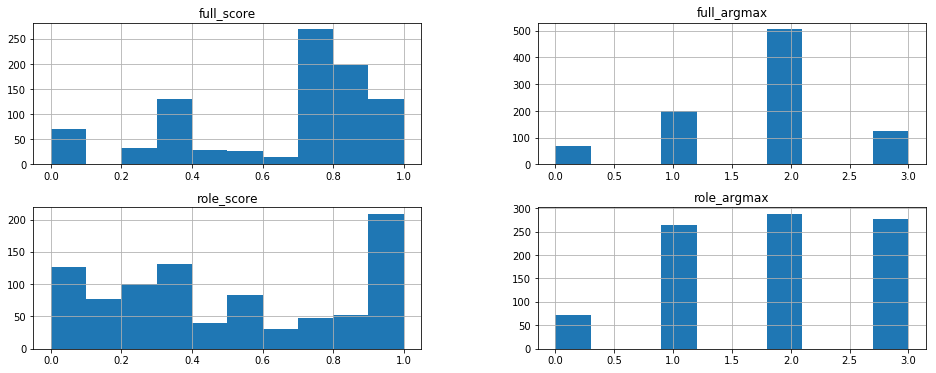

In [221]:
%matplotlib inline
def score_func(x, norm=True):
    kind = 'mulmax'
    if kind=='last':
        xx = x[-1]
    elif kind=='mulmax':
        xx = x.argmax(axis=1)*x.max(axis=1)
    elif kind=='maxadjust':
        xx = np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,x.argmax(axis=1))])
    elif kind == '1234':
        xx = np.sum(x * np.array([1, 2, 3, 4]), axis=1)
    elif kind == '1246':
        xx = np.sum(x * np.array([1, 2, 4, 6]), axis=1)
    elif kind=='1245':
        xx = np.sum(x * np.array([1, 2, 4, 5]), axis=1)
    else:
        raise AttributeError('meh.')
        
    return (xx-xx.min())/(xx-xx.min()).max()

distribution_full = []
distribution_role = []
scores_full = []
scores_role = []

scored_full = []
scored_role = []

for role, frm in data.test.groupby('grp'):
    print(role, len(frm))
    fmpred, fmppred = fm.predict(frm)
    mpred, mppred = m[role].predict(frm)
    
    tmp = frm.copy()
    tmp['SCORE'] = score_func(fmppred)
    scored_full.append(tmp)
    
    tmp = frm.copy()
    tmp['SCORE'] = score_func(mppred)
    scored_role.append(tmp)
    
    distribution_full += list(fmpred)
    distribution_role += list(mpred)
    scores_full += list(score_func(fmppred))
    scores_role += list(score_func(mppred))
    
classifier = 'bow'
cols = ['SCORE', 'UNIQUE_ID', 'DOCUMENT_TYPE', 'FILER_NAME', 'FILER_CIK', 'FILING_INTERVAL', 'FILING_DATE', 
        'MENTIONED_FINANCIAL_ENTITY', 'ROLE', 'THREE_SENTENCES']

pd.concat(scored_full).sort_values(by=['grp', 'SCORE'], 
                                   ascending=[True, False])[cols].to_csv('scored_full_'+classifier+'.csv',
                                                                         index=False)
pd.concat(scored_role).sort_values(by=['grp', 'SCORE'], 
                                   ascending=[True, False])[cols].to_csv('scored_role_'+classifier+'.csv',
                                                                         index=False)


f, ax = plt.subplots(figsize=(16,6), nrows=2, ncols=2)
pd.DataFrame({'full_score':scores_full}).hist(ax=ax[0][0])
pd.DataFrame({'full_argmax':distribution_full}).hist(ax=ax[0][1])
pd.DataFrame({'role_score':scores_role}).hist(ax=ax[1][0])
pd.DataFrame({'role_argmax':distribution_role}).hist(ax=ax[1][1])

# Experiment with scoring functions

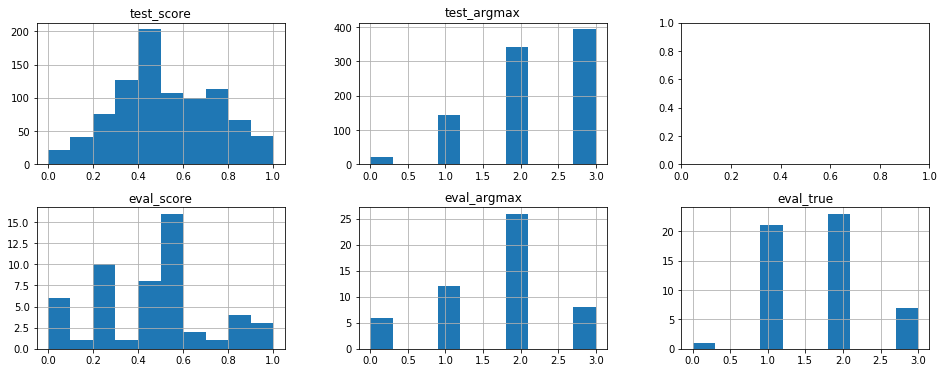

,test
count,900.000000
mean,0.522213
std,0.221250
min,0.000000
25%,0.384295
50%,0.489785
75%,0.698920
max,1.000000


In [206]:
%matplotlib inline
def score_func(x, norm=True):
    #return x.argmax(axis=1)
    #return np.sum(x * (np.ones_like(x)+ x.argmax(axis=1)), axis=1)
    #xx = ((x.argmax(axis=1))*x.argmax(axis=1)*x.max(axis=1))
    #xx= np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,a)])
    #xx = x.argmax(axis=1)+x.max(axis=1)
    #xx = x.argmax(axis=1)*x.max(axis=1)*x.max(axis=1)
    #return xx
    kind = 'mulmax'
    if kind=='last':
        xx = x[-1]
    elif kind=='mulmax':
        xx = x.argmax(axis=1)*x.max(axis=1)
    elif kind=='maxadjust':
        xx = np.array([ai-xi[ai:ai+1].sum()+xi[ai+1:].sum() for xi,ai in zip(x,x.argmax(axis=1))])
    elif kind == '1234':
        xx = np.sum(x * np.array([1, 2, 3, 4]), axis=1)
    elif kind == '1246':
        xx = np.sum(x * np.array([1, 2, 4, 6]), axis=1)
    elif kind=='1245':
        xx = np.sum(x * np.array([1, 2, 4, 5]), axis=1)
    else:
        raise AttributeError('meh.')
        
    return (xx-xx.min())/(xx-xx.min()).max()

#pred, ppred = fm.predict(data.test)
#epred, eppred = fm.predict(data.eval)

f, ax = plt.subplots(figsize=(16,6), nrows=2, ncols=3)
pd.DataFrame({'test_score':score_func(ppred)}).hist(ax=ax[0][0])
pd.DataFrame({'test_argmax':pred}).hist(ax=ax[0][1])
pd.DataFrame({'eval_true':data.get_target(frm='eval')}).hist(ax=ax[1][2])
pd.DataFrame({'eval_score':score_func(eppred)}).hist(ax=ax[1][0])
pd.DataFrame({'eval_argmax':epred}).hist(ax=ax[1][1])
plt.show()
pd.DataFrame({'test':score_func(ppred, norm=False)}).describe()
#pd.DataFrame({'eval':score_func(eppred)})
#pd.DataFrame({'ppred':score_func(ppred), 'eppred':score_func(eppred)}).describe()